In [19]:
# user defined functions
import odor_statistics_lib as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
from scipy import stats
import scipy.stats as st

#classification
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix

#plots
import string
import figurefirst
from figurefirst import FigureLayout,mpl_functions
import matplotlib.ticker as mtick
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None

In [2]:
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'

In [3]:
fdf_windy = pd.read_hdf(dir+'Windy/WindyStats.h5')
fdf_notwindy = pd.read_hdf(dir+'NotWindy/NotWindyStats.h5')
fdf_forest = pd.read_hdf(dir+'Forest/ForestStats.h5')

In [3]:
# acc = pd.read_hdf(dir+'Classifier/accuracy_Scores_desert_nwindy.h5')

## Classify

In [4]:
def create_class_column_forest(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 5, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 5)  & (dataframe.avg_dist_from_source < 10), 'type'] = 1
    dataframe.loc[dataframe.avg_dist_from_source >= 10, 'type'] = 2
    return dataframe

def create_class_column(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 5, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 5)  & (dataframe.avg_dist_from_source < 30), 'type'] = 1
    dataframe.loc[dataframe.avg_dist_from_source >= 30, 'type'] = 2
    return dataframe

def create_class_column_log(dataframe):
    dataframe.loc[dataframe.log_avg_dist_from_source_signed < 0.7, 'type'] = 0
    dataframe.loc[(dataframe.log_avg_dist_from_source_signed >= 0.7)  & 
                  (dataframe.log_avg_dist_from_source_signed < 1.5), 'type'] = 1
    dataframe.loc[dataframe.log_avg_dist_from_source_signed >= 1.5, 'type'] = 2
    return dataframe

def check_length(dataframe, Nrows, nrows,N):
    if (len(Nrows) !=N):
        rowsneeded  = N - len(Nrows) 
        Nrows = Nrows.append(dataframe[(nrows.index-rowsneeded).values[0]:(nrows.index).values[0]])
        Nrows = Nrows.sort_index()
        return Nrows
    else:
        return Nrows
    
def get_rows(dataframe, N):
    nrows = dataframe.sample(1)
    Nrows = dataframe[(nrows.index).values[0]:(nrows.index+N).values[0]]
    newrows = check_length(dataframe,Nrows, nrows, N)
    return newrows

# for each collection of data to use for the classifier, get statistics from N encounters
def get_N_consecutive_encounter_stats(dataframe, distance_class, N):
    df_q = dataframe.query('type == ' + str(distance_class))   
    df_q.reset_index(inplace=True, drop=True)     
    Nrows = get_rows(df_q,N)
    
    return np.ravel( Nrows[['mean_concentration','mean_ef','log_whiff','mean_ma']].values )


# for each collection of data to use for the classifier, get statistics from N encounters
def get_N_random_encounter_stats(dataframe, distance_class, N):
    df_q = dataframe.query('type == ' + str(distance_class))   
    df_q.reset_index(inplace=True, drop=True)     
    Nrows = df_q.sample(N)
    return np.ravel( Nrows[['mean_concentration','mean_ef','log_whiff','mean_ma']].values )


def gather_stat_random(dataframe, distance_class, number_of_encounters,X,y):
    for i in range(100):
        X.append(get_N_random_encounter_stats(dataframe, distance_class, number_of_encounters))
        y.append(distance_class)
    return X,y

def gather_stat_consecutive(dataframe, distance_class, number_of_encounters,X,y):
    for i in range(2000):
        X.append(get_N_consecutive_encounter_stats(dataframe, distance_class, number_of_encounters))
        y.append(distance_class)
    return X,y

def stack_arrays(a):
    A = np.full((len(a), max(map(len, a))), np.nan)
    for i, aa in enumerate(a):
        A[i, :len(aa)] = aa
    return A

# def class_population_accuracy(ytest,y_pred):
    
#     cm = confusion_matrix(ytest, y_pred)
#     return ((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).diagonal())

def class_population_accuracy(ytest,y_pred):
    cm = confusion_matrix(ytest, y_pred)
    class_acc=[]
    # Calculate the accuracy for each one of our classes
    for idx, cls in enumerate([0,1,2]):
        # True negatives are all the samples that are not our current GT class (not the current row) 
        # and were not predicted as the current class (not the current column)
        tn = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
        # True positives are all the samples of our current GT class that were predicted as such
        tp = cm[idx, idx]
        # The accuracy for the current class is ratio between correct predictions to all predictions
        class_acc.append((tp+tn)/np.sum(cm))
    return (class_acc)

### Creating various Distance bins

In [4]:
# fdf_windy=fdf_windy.drop(columns=['type'])
# fdf_notwindy=fdf_notwindy.drop(columns=['type'])
# fdf_forest=fdf_forest.drop(columns=['type'])

# def create_class_column_log(dataframe):
#     dataframe.loc[dataframe.log_avg_dist_from_source_signed < 0.85, 'type'] = 0
#     dataframe.loc[(dataframe.log_avg_dist_from_source_signed >= 1.05)  & 
#                   (dataframe.log_avg_dist_from_source_signed < 1.4), 'type'] = 1
#     dataframe.loc[dataframe.log_avg_dist_from_source_signed >= 1.5, 'type'] = 2
#     return dataframe

# fdf_windy = create_class_column_log(fdf_windy)
# fdf_notwindy = create_class_column_log(fdf_notwindy)
# fdf_forest = create_class_column_log(fdf_forest)

# fdf_windy=fdf_windy.replace(np.nan, 10)
# fdf_notwindy=fdf_notwindy.replace(np.nan, 10)
# fdf_forest=fdf_forest.replace(np.nan, 10)

# fdf_windy.to_hdf(dir+'Windy/WindyStats_n.h5', key='fdf_windy', mode='w')
# fdf_notwindy.to_hdf(dir+'NotWindy/NotWindyStats_n.h5', key='fdf_notwindy', mode='w')
# fdf_forest.to_hdf(dir+'Forest/ForestStats_n.h5', key='fdf_forest', mode='w')

### Plotting Classwise Accuracy

In [5]:
# acc.drop(list(acc.filter(regex = 'feature')), axis = 1, inplace = True)
feature_number=np.arange(1,51,1)
confidence_interval_1=[]
confidence_interval_2=[]
confidence_interval_3=[]
median_1=[]
median_2=[]
median_3=[]
for i in range(0,len(acc.columns),3):
    confidence_interval_1.append(st.t.interval(alpha=0.95, 
                                              df=len(acc)-1, loc=np.mean(acc.iloc[:,i]), 
                                              scale=st.sem(acc.iloc[:,i]))) 
    median_1.append(np.median(acc.iloc[:,i]))

    confidence_interval_2.append(st.t.interval(alpha=0.95, 
                                              df=len(acc)-1, loc=np.mean(acc.iloc[:,i+1]), 
                                              scale=st.sem(acc.iloc[:,i+1]))) 
    median_2.append(np.median(acc.iloc[:,i+1]))
    confidence_interval_3.append(st.t.interval(alpha=0.95, 
                                              df=len(acc)-1, loc=np.mean(acc.iloc[:,i+2]), 
                                              scale=st.sem(acc.iloc[:,i+2], nan_policy='omit'))) 
    median_3.append(np.median(acc.iloc[:,i+2]))
    
## storing in a dataframe
df_interval = pd.DataFrame({'cl_1_int_1': np.array(confidence_interval_1)[:,0],
                        'cl_1_int_2': np.array(confidence_interval_1)[:,1],
                        'cl_2_int_1': np.array(confidence_interval_2)[:,0],
                        'cl_2_int_2': np.array(confidence_interval_2)[:,1],
                        'cl_3_int_1': np.array(confidence_interval_3)[:,0],
                        'cl_3_int_2': np.array(confidence_interval_3)[:,1],
                        'median_cl_1':median_1,
                        'median_cl_2':median_2,
                        'median_cl_3':median_3,
                        'feature':feature_number})

In [6]:
df_interval.isnull().values.any()
## Interpolating NaNs
# df_interval.cl_3_int_1 = df_interval.cl_3_int_1.interpolate(method='nearest')
# df_interval.cl_3_int_2 = df_interval.cl_3_int_2.interpolate(method='nearest')

In [7]:
f,ax=plt.subplots(1,1,figsize=(8,6))
ax.grid(False)
ax.scatter(df_interval.feature, df_interval.median_cl_1, label='Median Class 1 - 0<D<7m')
ax.scatter(df_interval.feature, df_interval.median_cl_2, label='Median Class 2 - 11m<D<25m')
ax.scatter(df_interval.feature, df_interval.median_cl_3, label='Median Class 3 - D>30m')

ax.fill_between(df_interval.feature, df_interval['cl_1_int_1'], df_interval['cl_1_int_2'],
                where=df_interval['cl_1_int_2'] >= df_interval['cl_1_int_1'],
                facecolor='blue', alpha=0.2, interpolate=True)

ax.fill_between(df_interval.feature, df_interval['cl_2_int_1'], df_interval['cl_2_int_2'],
                where=df_interval['cl_2_int_2'] >= df_interval['cl_2_int_1'],
                facecolor='blue', alpha=0.2, interpolate=True)

ax.fill_between(df_interval.feature, df_interval['cl_3_int_1'], df_interval['cl_3_int_2'],
                where=df_interval['cl_3_int_2'] >= df_interval['cl_3_int_1'],
                facecolor='blue', alpha=0.2, interpolate=True)
ax.set_xlabel('N_Features')
ax.set_ylabel('% Class Accuracy')

mpl_functions.adjust_spines(ax,['left','bottom'],spine_locations={}, 
                                smart_bounds=True,
                                xticks=[0,10,20,30,40,50],
#                                 yticks=[0.5,0.8],
                                linewidth=1)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Desert tested on LWS')
figurefirst.mpl_functions.set_fontsize(f, 18)

f.tight_layout(pad=2)
f.savefig('../../Figure/accuracy_desert_nwindy.jpeg', dpi=300, bbox_inches = "tight")

False

### Get Classwise Accuracy

In [16]:
accuracy = []

number_of_encounters = 15
trainset= fdf_notwindy
testset = fdf_windy

for i in range (0,5): #bootstrapping
    Xtest = []
    ytest = []
    Xtrain = []
    ytrain = []
    
    for distance_class in [0,1,2]:
        Xtrain,ytrain = gather_stat_random(trainset,distance_class,number_of_encounters, Xtrain,ytrain) 
    Xtrain = stack_arrays(Xtrain)


    for distance_class in [0,1,2]:
        Xtest,ytest = gather_stat_random(testset,distance_class,number_of_encounters, Xtest,ytest)    
    Xtest = stack_arrays(Xtest)
    
    clf = GaussianNB()
    y_pred = clf.fit(Xtrain,ytrain).predict(Xtest)
    
    accuracy.append(class_population_accuracy(ytest,y_pred))


In [ ]:
accdf=pd.DataFrame()
accdf['class_0']=[item[0] for item in accuracy]
accdf['class_1']=[item[1] for item in accuracy]
accdf['class_2']=[item[2] for item in accuracy]

In [6]:
number_of_encounters = 15
desert = pd.concat([fdf_notwindy,fdf_windy])
trainset= desert 
testset = fdf_windy

Xtest = []
ytest = []
Xtrain = []
ytrain = []

for distance_class in [0,1,2]:
    Xtrain,ytrain = gather_stat_random(trainset,distance_class,number_of_encounters, Xtrain,ytrain) 
Xtrain = stack_arrays(Xtrain)


for distance_class in [0,1,2]:
    Xtest,ytest = gather_stat_random(testset,distance_class,number_of_encounters, Xtest,ytest)    
Xtest = stack_arrays(Xtest)

In [26]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [30]:
## TRAINED WITH NOT WINDY AND TESTED on WINDY
# clf = GaussianNB()


kernel = 1.0 * RBF(1.0)
clf = GaussianProcessClassifier(kernel=kernel,
        random_state=0)
n=2
y_pred = clf.fit(Xtrain[:,:n],ytrain).predict(Xtest[:,:n])
print("Naive Bayes Test set Score: ",clf.score(Xtest[:,:n], ytest))

# # print("Naive Bayes Train set Score: ",clf.score(Xtrain, ytrain))
print("Number of mislabeled points out of a total %d points : %d"
      % (Xtest[:,:n].shape[0], (ytest != y_pred).sum()))

Naive Bayes Test set Score:  0.5233333333333333
Number of mislabeled points out of a total 300 points : 143


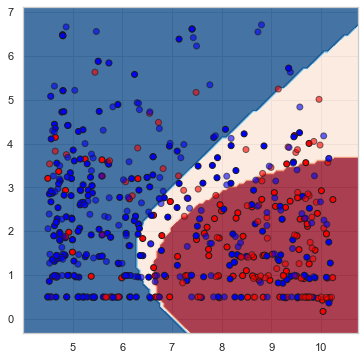

In [24]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
f,ax = plt.subplots(1,1,figsize=(6, 6))
DecisionBoundaryDisplay.from_estimator(
            clf, Xtrain[:,:n], cmap=cm, alpha=0.8, ax=ax, eps=0.5)
# Plot the training points
ax.scatter(
    Xtrain[:, 0], Xtrain[:, 1], c=ytrain, cmap=cm_bright, edgecolors="k"
)
# Plot the testing points
ax.scatter(
    Xtest[:, 0],
    Xtest[:, 1],
    c=ytest,
    cmap=cm_bright,
    edgecolors="k",
    alpha=0.6,
)

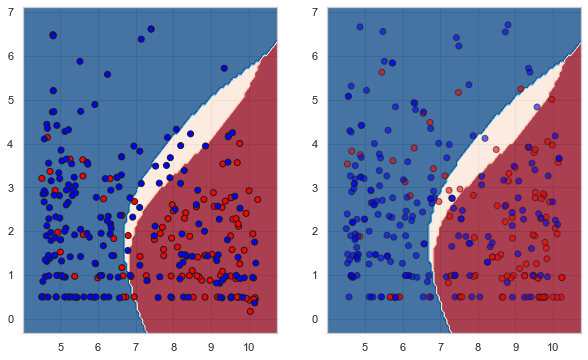

In [43]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
f,ax = plt.subplots(1,2,figsize=(10, 6))
DecisionBoundaryDisplay.from_estimator(
            clf, Xtrain[:,:n], cmap=cm, alpha=0.8, ax=ax[0], eps=0.5)
DecisionBoundaryDisplay.from_estimator(
            clf, Xtrain[:,:n], cmap=cm, alpha=0.8, ax=ax[1], eps=0.5)
# Plot the training points
ax[0].scatter(
    Xtrain[:, 0], Xtrain[:, 1], c=ytrain, cmap=cm_bright, edgecolors="k"
)
# Plot the testing points
ax[1].scatter(
    Xtest[:, 0],
    Xtest[:, 1],
    c=ytest,
    cmap=cm_bright,
    edgecolors="k",
    alpha=0.6,
)

In [90]:
print("Accuracy:",metrics.accuracy_score(ytest, y_pred))
# print(metrics.classification_report(ytest, y_pred))

Accuracy: 0.7183333333333334


## Gradient Descent

In [ ]:
# def gradient_descent(gradient, start, learn_rate, n_iter=50, tolerance=1e-06):
#     vector = start
   
#     for _ in range(n_iter):
#         diff = -learn_rate * gradient(vector)
#         if np.all(np.abs(diff) <= tolerance):
#             break
#         vector += diff
#         a.append(vector)
#     return vector


# a = []
# vector = gradient_descent(
#     gradient=lambda v: 4 * v**3 - 10 * v - 3, start=0,
#     learn_rate=0.1
# )


# def f(x):
# #     return np.sin(x) + x + x * np.sin(x)
#     return 4 * np.power(x,3) - 10*x -3\


# x = np.linspace(-3, 3, 50)
# plt.plot(x,f(x))
# plt.plot(a,'o')
# plt.xlim(-3,3)

## Model theoretical whiff frequency as a gamma distribution with a scale factor that increases with distance

In [ ]:
def whiff_freq_from_distance(distance, N):
    scale = 1 + 4*np.log(distance+1)
    G = scipy.stats.gamma(2, 0, scale)
    raw_whiff_frequencies = G.rvs(N)
    return raw_whiff_frequencies

distance = np.logspace(-1, 3)

whiff_freqs = []
distances = []
for d in distance:
    N = 100
    wfs = whiff_freq_from_distance(d, N)
    whiff_freqs.extend( wfs.tolist() )
    distances.extend(N*[d])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot( np.array(distances), np.array(whiff_freqs), '.', alpha=0.3)
ax.set_xscale('log')
ax.set_xlim(1e-1, 1e2)

# With increasing distance, concentration falls, whiffs harder to detect, so frequency should fall

Model concentration effect as a normal distribution with a mean that falls according to an exponential distribution

In [ ]:
def concentration_effect_from_distance(distance, N):
    mean = scipy.stats.expon(0,40).pdf(d) / 0.025
    concentration_effects = scipy.stats.norm(mean, 0.3).rvs(N)
    concentration_effects[concentration_effects<0] = 0
    return concentration_effects

distance = np.logspace(-1, 3)

conc_effects = []
distances = []
for d in distance:
    N = 100
    ces = concentration_effect_from_distance(d, N)
    conc_effects.extend( ces.tolist() )
    distances.extend(N*[d])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot( np.array(distances), np.array(conc_effects), '.', alpha=0.3)
ax.set_xscale('log')
ax.set_xlim(1e-1, 1e2)

# Model observed whiff frequency as a product of the two

In [ ]:
whiff_freqs = []
distances = []
concentrations = []
for d in distance:
    N = 100
    
    raw_whiff_frequencies = whiff_freq_from_distance(d, N)
    concentration_effects = concentration_effect_from_distance(d, N)
    
    wfs = raw_whiff_frequencies*concentration_effects
    wfs = wfs / 10
    
    whiff_freqs.extend( wfs.tolist() )
    distances.extend(N*[d])
    concentrations.extend(concentration_effects)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot( np.array(distances), np.array(whiff_freqs), '.', alpha=0.3)

ax.set_xscale('log')
ax.set_xlim(1e-1, 1e2)
ax.set_ylim(0, 8)

In [ ]:
df = pd.DataFrame({'distance': distances, 
                       'whiff_freq': whiff_freqs, 
                       'concentration': concentrations,
                       'type': [0]*len(whiff_freqs)})